In [1]:
import jax
import jax.numpy as jnp
import optax
from jax import vmap,  value_and_grad

from matplotlib import pyplot as plt
%config InlineBackend.figure_format='retina'

import tensorflow_datasets as tfds
import time

/Users/ndalcin/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/ndalcin/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# CNNs with JAX

In [7]:
# NETWORK FUNCTIONS:

# Multi Layer Perceptron

def MLP (x, params):
    """
    Standard multilayer perception "MLP" with params['weights'] and params['biases'],
    applied to input vector x. 
    Activation: tanh (applied to all layers except last).
    
    Returns activation vector of the output layer.

    x: np.array
    params: dict
    """

    num_layers = len(params['biases'])
    for idx_layer, (w,b) in enumerate(zip(params['weights'], params['biases'])):
        x = jnp.matmul(w,x) + b
        if idx_layer < num_layers - 1:
            x = jnp.tanh(x)
    return x


# Convolutional Neural Network

# To implement a CNN we need a "kernel" to be convoluted to an image with N channels (e.g. 3 for RedGreenBlue )
# and returns an output image with M channels
# so kernel has shape [M,N,K,K] where K = quare_kernel_dimension


def conv2d( img, kernel, scalefactor ):
    """
    Shortcut for jax convolution of kernel with
    image 'img', with padding 'VALID' and possibly scaling down by
    a factor (which should ideally divide the img size).
    """
    # How to handle boundary pixels?
    # "VALID" : keep output pixels where the kernel extent still fits into the input image completely 
    # "SAME"  : strive to keep the image size overall the same
    return jax.lax.conv_general_dilated(img, kernel, [scalefactor,scalefactor], "VALID") 


def CNN( x, params ):
    """
    Apply several convolutional layers and then
    switch to fully connected. The structure here
    is fixed.
    
    params must contain params['conv_kernels'],
    params['conv_biases'] for the convolutional
    part and params['dense'] containing weights
    and biases for the dense part.
    """
    # first add a fake batch dimension, because we
    # will deal with batching separately later
    # using vmap, but jax.lax.conv needs a batch
    # dimension (here of size 1):
    x = x[None,...]
    
    # apply several 2d convolutions and downscalings by factor of 2:
    for kernel, bias in zip(params['conv_kernels'],params['conv_biases']):
        x = conv2d( x, kernel, 2 ) + bias[None,:,None,None]
        x = jnp.tanh( x )
        
    # now switch to dense network, "flattening" the image and 
    # its channels into a single vector
    x = jnp.reshape( x, [-1] )
    
    # finally, apply the usual dense network, with its weights 
    # and biases provided inside params['dense']:
    return MLP( x, params['dense'] )

In [8]:
# PARAMETERS INITIALIZATOR FUNCTONS

# MLP parameters

def MLP_init_params(key, num_layers):
    """
    Given a jax random key and a list of the neuron numbers
    in the layers of a network (simple fully connected network,
    i.e. 'multi-layer perceptron'), return a dictionary
    with the weights initialized randomly and biases set to zero.
    
    Returns: params, with params['weights'] a list of matrices and
    params['biases'] a list of vectors.
    """
    params = {}
    params['weights'] = []
    params['biases'] = []
    
    for in_layer, out_layer in zip( num_layers[:-1], num_layers[1:] ):
        key,subkey = jax.random.split( key )
        params['weights'].append( jax.random.normal( subkey,[out_layer,in_layer] ) / jnp.sqrt( in_layer ) )
        
    for num_neurons in num_layers[1:]:
        params['biases'].append( jnp.zeros( num_neurons) )
    
    return params

def CNN_init_params( key, pixel_rows, pixel_cols,
                        num_channels, kernel_sizes,
                        final_dense_layers ):
    """
    Randomly initialize the parameters needed for
    a convolutional+dense neural network.
    
    key: jax random key
    pixel_rows, pixel_cols: dimensions of input image
       (needed to properly set up the dense part!)
    num_channels: list of channels for the conv. part,
       starting with the input image channels
    kernel_sizes: listing the sizes of the kernels,
       a list of length one less than num_channels
    final_dense_layers: list of numbers of neurons in
       the final few dense layers (excluding the
       first dense layer, which results from flattening
       the convolutional output, whose neuron number is
       computed automatically from the image dim.
       given above)
       
    Returns params dictionary with entries
    'conv_kernels', 'conv_biases', and 'dense'.
    """
    params = {}
    params['conv_kernels']=[]
    params['conv_biases']=[]
    
    for in_channels, out_channels, kernel_size in zip( num_channels[:-1], num_channels[1:], kernel_sizes ):
        key,subkey = jax.random.split( key )
        params['conv_kernels'].append( jax.random.normal( subkey,
                                        [out_channels,in_channels,kernel_size,kernel_size] ) /  
                                 jnp.sqrt( in_channels ) )
        # keep track of image shape during these convolutions and
        # downscalings! (change this if you use 'SAME' instead of 'VALID')
        pixel_rows = ( pixel_rows - (kernel_size-1) + 1 ) // 2
        pixel_cols = ( pixel_cols - (kernel_size-1) + 1 ) // 2

    for channels in num_channels[1:]:
        params['conv_biases'].append( jnp.zeros( channels ) )

    # now we switch to the dense network!
    # need to calculate the size of the input vector
    # to the fully connected (dense) network:
    neuron_num_input = num_channels[-1] * pixel_rows * pixel_cols
    key,subkey = jax.random.split( key )
    params['dense'] = MLP_init_params( subkey, [neuron_num_input] + final_dense_layers )
    
    return params

In [9]:
# In JAX, to handle batches of input, we simply create a new function with "vmap"
# "vmap" creates a new function of the network which can handle an additional dimension (for the batch)
# we only need to specify which input and output variables the batch refers to.
# In the MLP case, these are the x and y = MPL(x, params), which are the 0-th entry of the input/output

MLP_batch = vmap( MLP, in_axes = [0,None],out_axes = 0) # for the variables unaffected by the batch we just insert 'None'

# produce a batched version (where x has a batch dimension 0)
NN_conv_batch = vmap(CNN, in_axes=[0,None], out_axes=0)



In [10]:
# BATCHED NETWORK FUNCTIONS:
# batch-averaged mean-square-error deviation between x and y_target:
# y_target is the vector of outputs (for the several batches)

def mse_loss_batch(x, y_target, params):
    return jnp.sum( ( MLP_batch(x,params) - y_target )**2 ) / jnp.shape(x)[0]

def mse_loss_conv_batch(x, y_target, params):
    return jnp.sum( ( NN_conv_batch(x,params) - y_target )**2 ) / jnp.shape(x)[0]

def cross_entropy_loss_conv_batch(x, y_target, params):
    """
    Computes the cross-entropy loss for a batch of predictions and one-hot encoded targets.
    Args:
        x: Input data (e.g., images), shape [batch_size, ...].
        y_target: One-hot encoded target labels, shape [batch_size, num_classes].
        params: Model parameters.
    Returns:
        Scalar cross-entropy loss for the batch.
    """
    logits = NN_conv_batch(x, params)  # Output logits from the neural network
    log_probs = jax.nn.log_softmax(logits)  # Log-probabilities
    loss = -jnp.sum(y_target * log_probs) / jnp.shape(x)[0]  # Cross-entropy loss
    return loss


In [11]:
# MLP GRADIENTS:
# "jax.value_and_grad" takes gradient with respect to params (argument number '2' out of 0,1,2)
# also return value of loss:
mse_loss_batch_val_grad = value_and_grad(mse_loss_batch, argnums=2)

# "jax.jit" makes "just in time" compilation -> it speeds-up the code both on CPU and GPU
mse_loss_batch_val_grad = jax.jit( mse_loss_batch_val_grad  )


# CNN GRADIENTS:
mse_loss_conv_batch_val_grad = jax.jit( value_and_grad(mse_loss_conv_batch, argnums=2) )

cross_entropy_loss_conv_batch_val_grad = jax.jit(value_and_grad(cross_entropy_loss_conv_batch, argnums=2))


# MNIST dataset

In [12]:
# Hyperparameters and itialization

output_dim = 10 # number of labels 
npixels = 28 # side of a square image (28 for MNIST dataset)
learning_rate = 1e-3

key = jax.random.key(31)

subkey, key = jax.random.split(key)
params = CNN_init_params( subkey, 
                pixel_rows=npixels, pixel_cols=npixels,
                num_channels=[1,32,64,10], 
                # in the MNIST we have num_in_channels == num_out_channels == 1
                # we also use a kernel of size == 3
                kernel_sizes=[1,3,3,1],
                final_dense_layers=[64,output_dim] )

optimizer = optax.adam( learning_rate )
opt_state = optimizer.init( params )

In [14]:
# Load and preprocess MNIST training data
def load_mnist_data():
    ds_builder = tfds.builder('mnist')
    ds_builder.download_and_prepare()
    datasets = ds_builder.as_dataset(split=['train', 'test'], as_supervised=True)

    def preprocess(image, label):
        # Normalize images to range [0, 1] and reshape to 28x28x1
        image = jnp.array(image.numpy() / 255.0).reshape(1, 28, 28)  # reshape to 28x28x1
        label = jnp.array(label.numpy())
        return image, label

    train_data = [(preprocess(img, lbl)) for img, lbl in datasets[0]]
    test_data = [(preprocess(img, lbl)) for img, lbl in datasets[1]]

    return train_data, test_data

train_data, test_data = load_mnist_data()


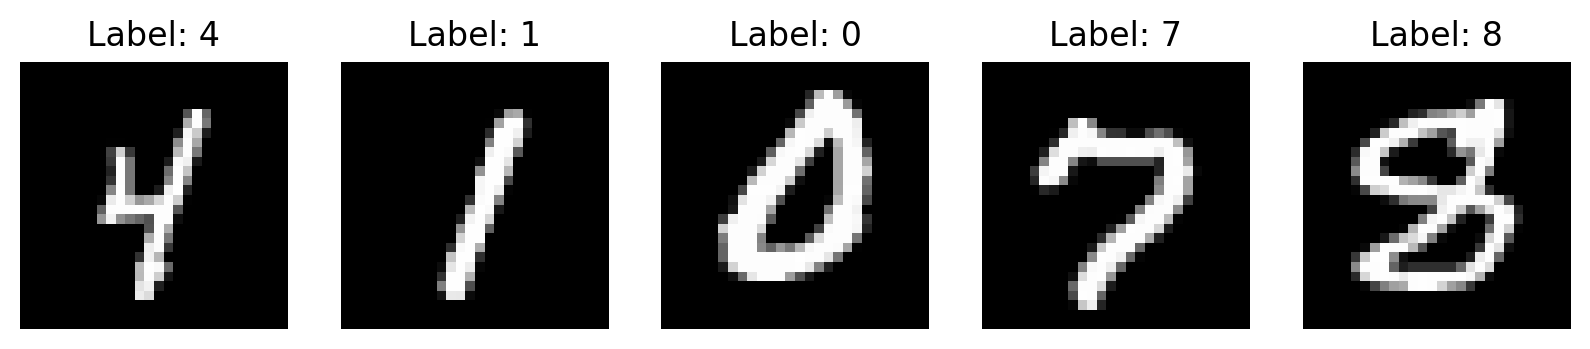

In [15]:
# Visualize some samples in the dataset

def show_samples(data, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(num_samples * 2, 2))
    for i in range(num_samples):
        image, label = data[i]
        axes[i].imshow(image.squeeze(), cmap='gray') 
        axes[i].axis('off') 
        axes[i].set_title(f"Label: {label}")
    plt.show()

show_samples(train_data, num_samples=5)

In [ ]:
def train_conv_model(train_data, params, optimizer, opt_state, batch_size=60, num_training_batches=1000):
    """
    Train a convolutional neural network using cross-entropy loss and output training time.

    Args:
    - train_data: Dataset containing tuples of (image, label)
    - params: Initial parameters of the model
    - optimizer: Optax optimizer for parameter updates
    - opt_state: Initial state of the optimizer
    - batch_size: Number of samples per training batch
    - num_training_batches: Total number of training batches

    Returns:
    - params: Trained model parameters
    - losses: List of loss values per batch
    """
    # List to store losses
    losses = []

    # Record start time
    start_time = time.time()

    # Training loop
    for idx_batch in range(num_training_batches):
        # Slice the batch from train_data
        batch_data = train_data[idx_batch * batch_size : (idx_batch + 1) * batch_size]
        
        # Unpack the images and labels separately
        x = jnp.array([d[0] for d in batch_data])  # Extract images: Shape (batch_size, 28, 28, 1)
        y_target = jnp.array([d[1] for d in batch_data])  # Extract labels: Shape (batch_size,)
        
        # Convert y_target to one-hot encoding
        y_target_one_hot = jax.nn.one_hot(y_target, num_classes=10)  # Shape: (batch_size, 10)

        # Get the cross-entropy loss and gradients with respect to network parameters
        loss, grads = cross_entropy_loss_conv_batch_val_grad(x, y_target_one_hot, params)

        # Update the parameters using the optimizer
        updates, opt_state = optimizer.update(grads, opt_state)
        params = optax.apply_updates(params, updates)

        # Store the loss for plotting later
        losses.append(loss)

    # Calculate training time
    training_time = time.time() - start_time

    # Plot the loss curve
    plt.plot(losses)
    plt.title("Cross-entropy error loss vs training batch")
    plt.xlabel("Training batch")
    plt.ylabel("Loss")
    plt.show()

    # Print training time
    print(f"Training completed in {training_time:.2f} seconds")

    return params, losses

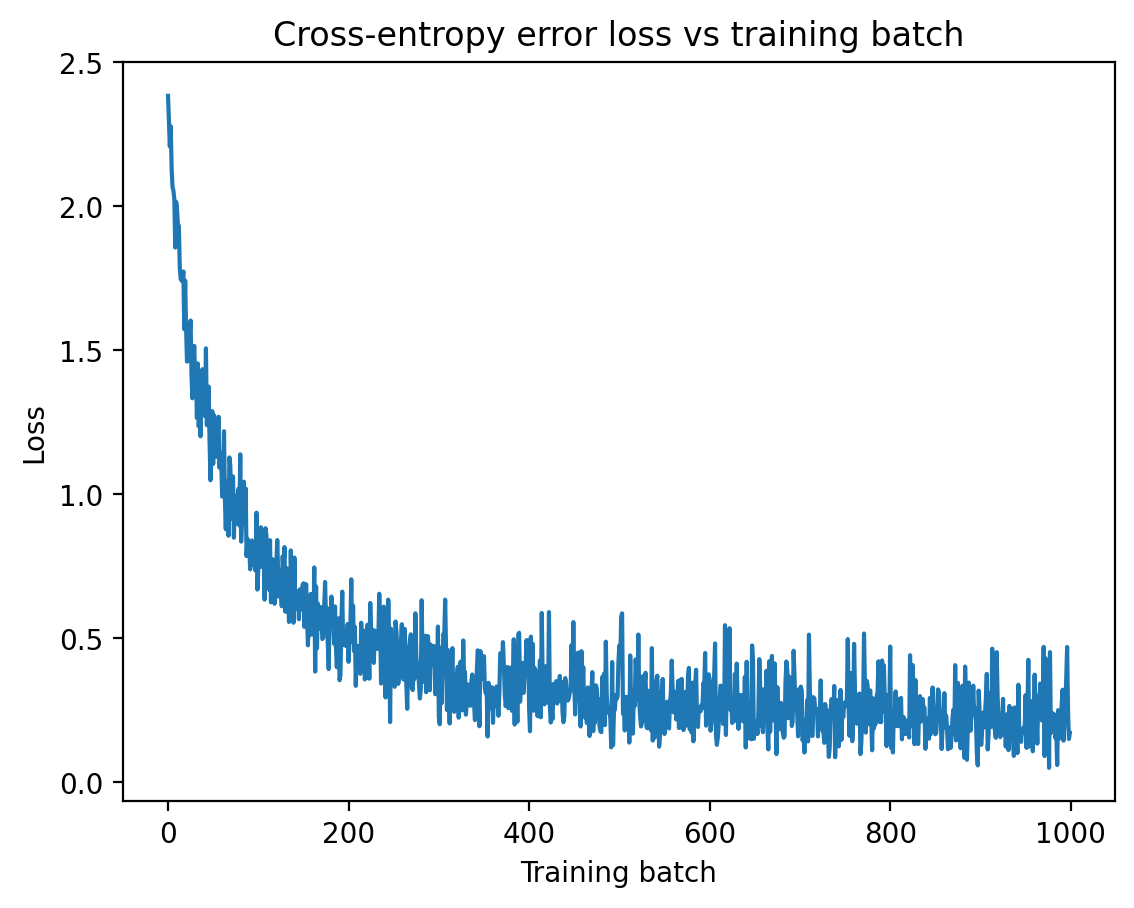

Training completed in 15.42 seconds


In [ ]:
trained_params, training_losses = train_conv_model(
    train_data = train_data,
    params = params,
    optimizer = optimizer,
    opt_state = opt_state,
    batch_size = 60,
    num_training_batches = 1000
)


In [ ]:
def evaluate_model(test_data, params):
    """
    Evaluate the CNN on the test dataset.
    Computes the average cross-entropy loss and accuracy.

    Args:
        - test_data: Preprocessed test data, list of (image, label) tuples.
        - params: Trained model parameters.

    Returns:
        - Average loss 
        - accuracy (on the test dataset).
    """
    batch_size = 100  # Define test batch size
    num_batches = len(test_data) // batch_size
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    for batch_idx in range(num_batches):
        # Extract a batch from test_data
        batch_data = test_data[batch_idx * batch_size : (batch_idx + 1) * batch_size]
        x = jnp.array([d[0] for d in batch_data])  # Extract images, shape (batch_size, 28, 28, 1)
        y_target = jnp.array([d[1] for d in batch_data])  # Extract integer labels, shape (batch_size,)

        # Convert y_target to one-hot encoding
        y_target_one_hot = jax.nn.one_hot(y_target, num_classes=10)  # Shape: (batch_size, 10)

        # Compute the logits
        logits = NN_conv_batch(x, params)  # Shape: (batch_size, 10)

        # Compute the loss
        log_probs = jax.nn.log_softmax(logits)  # Log probabilities
        loss = -jnp.sum(y_target_one_hot * log_probs) / batch_size  # Cross-entropy loss
        total_loss += loss

        # Compute predictions and accuracy
        predictions = jnp.argmax(logits, axis=1)  # Predicted class
        correct_predictions += jnp.sum(predictions == y_target)  # Count correct predictions
        total_samples += batch_size

    # Compute average loss and accuracy
    avg_loss = total_loss / num_batches
    accuracy = correct_predictions / total_samples
    return avg_loss, accuracy

In [ ]:
# Evaluate on test data
avg_loss, accuracy = evaluate_model(test_data, trained_params)

# Display results
print(f"Test Loss: {avg_loss:.4f}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Loss: 0.1945
Test Accuracy: 94.28%


# Duffing equation 

Duffing oscillator:

$$\dot{z}=-i(\omega_0-\omega)z-\frac{\gamma}{2}z - i \varepsilon|z|^2z+if,$$

Here 
- $\omega_0$ is the resonance frequency (counted from some offset that itself is already much larger than the damping rate and everything else), 
- $\omega$ is the driving frequency, 
- $\gamma$ the damping rate, and 
- $\varepsilon$ the strength of the nonlinearity, while 
- $f$ is the strength of the external oscillating force.

Credits: https://florianmarquardt.github.io/MachineLearningThreeEasyLessons/2024_09_Trieste_Duffing_Example.html

In [ ]:
from functools import partial
import tqdm

In [56]:
def runge_kutta_step_with_params(X,params,t,rhs,dt):
    """
    One step of the standard Runge-Kutta fourth order.
    This assumes rhs can be called like rhs(X,params,t)
    """
    k1=rhs(X,params,t)
    k2=rhs(X+0.5*dt*k1,params,t+0.5*dt)
    k3=rhs(X+0.5*dt*k2,params,t+0.5*dt)
    k4=rhs(X+dt*k3,params,t+dt)
    return( (dt/6.)*(k1+2*k2+2*k3+k4) )

# we need this partial statement to tell jax
# that the 'rhs' argument is not an array but something
# else!
@partial(jax.jit,static_argnames=['rhs'])
def runge_kutta_solve(X0,rhs,ts,params):
    """
    Solve the differential equation dX/dt=rhs(X,params,t), for all (equally spaced) times in ts,
    with initial value X(t=0)=X0.
    
    Here X0 can have ANY shape as an array, and rhs(X,params,t) must return the same shape.
    
    This is convenient in case you want to, say, do many trajectories in parallel,
    or reserve one index for the particle number, etc. You do not need to assume
    X to be a 1d array, as you would have to do for some other Runge-Kutta implementations.
    It is also nice to split the positions and velocities, e.g. X[0,:] for the positions
    of all particles, and X[1,:] for the velocities.
    
    Returns: Xs,ts
    
    where the shape of the solution Xs is the same as that of X, except we add another dimension
    at the end, of size 'nsteps'. 'ts' just is a 1d array denoting the time steps for
    the solution.
    
    Plotting the solution may work like this, if X was a 1d array:
    
    plt.plot(ts,Xs[5]) # Note that Xs[5] is the same as Xs[5,:]
    
    ...or like this, if e.g. X[1,:] were all the velocities of all particles:
    
    plt.plot(ts,Xs[1,3]) # plotting velocity of particle number 3: Xs[1,3] is the same as Xs[1,3,:]
    
    (code by Florian Marquardt 2020, 2024)
    """
    dt=ts[1]-ts[0]

    def loop_body(x,t):
        x+=runge_kutta_step_with_params(x,params,t,rhs,dt)
        return x,x
    
    _,Xs=jax.lax.scan(loop_body,X0,xs=ts)
    return Xs,ts

# batched parameters:
parallel_param_runge_kutta_solve = vmap(runge_kutta_solve,in_axes=[None,None,None,0],
                                                   out_axes=0)

# batched initial conditions:
parallel_runge_kutta_solve = vmap(runge_kutta_solve,in_axes=[0,None,None,None],
                                                   out_axes=0)

In [57]:
def duffing_rhs(z,rhs_params,t):
    # params = [omega_start, domega_dt , gamma, epsilon, force, omega0]
    return ( (-1j*(rhs_params[5]-(rhs_params[0]+rhs_params[1]*t)) - 0.5*rhs_params[2])*z 
            -1j*rhs_params[3]*jnp.abs(z)**2 * z + 1j*rhs_params[4] )

def solve_duffing(z0, omega0, gamma, epsilon, force, omega_start, omega_stop, t_end, nsteps):
    ts=jnp.linspace(0.,t_end, nsteps)
    domega_dt = (omega_stop - omega_start)/t_end 
    rhs_params=jnp.array([omega_start, domega_dt , gamma, epsilon, force, omega0])
    omegas=omega_start + domega_dt * ts
    return *runge_kutta_solve(z0, duffing_rhs, ts, rhs_params),omegas

# batch-processing version, where omega0,gamma,epsilon can vary across
# the samples of the batch:
solve_duffing_parameter_batch = vmap(solve_duffing,
                                    in_axes=[None,0,0,0,None,None,None,None,None])

# batch-processing version, which can be used to compute a force sweep:
solve_duffing_force_batch = vmap(solve_duffing,
                                 in_axes=[None,None,None,None,0,None,None,None,None],
                                out_axes=0)

In [58]:
def random_parameter_vectors( key, batchsize , ranges ):
    """
    Produce several vectors of length batchsize, with values randomly
    uniformly distributed within the respective values range [min_val,max_val].
    ranges is a list of such value ranges.
    
    Returns: list of random vectors.
    """
    subkeys = jax.random.split( key, len(ranges) )
    return [ jax.random.uniform( subkey, [ batchsize ], 
                                      minval = value_range[0], maxval = value_range[1] )
            for subkey, value_range in zip(subkeys, ranges) ]

def duffing_produce_training_batch( key, batchsize, ranges , num_frequency_bins,
                                  force=1.0, omega_start=-4.0, omega_end=+4.0,
                                  t_end=200.0, n_steps=400):
    """
    Produce a Duffing model training batch.
    Random values for omega0, gamma, and epsilon are generated uniformly
    in the ranges given in the list 'ranges' (a list of [min_val,max_val] entries).
    
    Returns:
    x, y_target
    
    where
    
    x is of shape [batchsize, num_frequency_bins] and represents the response curves
    y_target is of shape [batchsize, 3] and gives (omega0,gamma,epsilon) for each sample
    """
    omega0s, gammas, epsilons = random_parameter_vectors( key, batchsize, ranges )
    zs,_,_ = solve_duffing_parameter_batch( 0.0+0.0j, omega0s, gammas, epsilons, 
                                 force, omega_start, omega_end, t_end, n_steps )
    x = jax.image.resize( jnp.abs(zs), [ batchsize, num_frequency_bins ] , "linear")
    return x, jnp.stack([omega0s,gammas,epsilons],1)
     
    

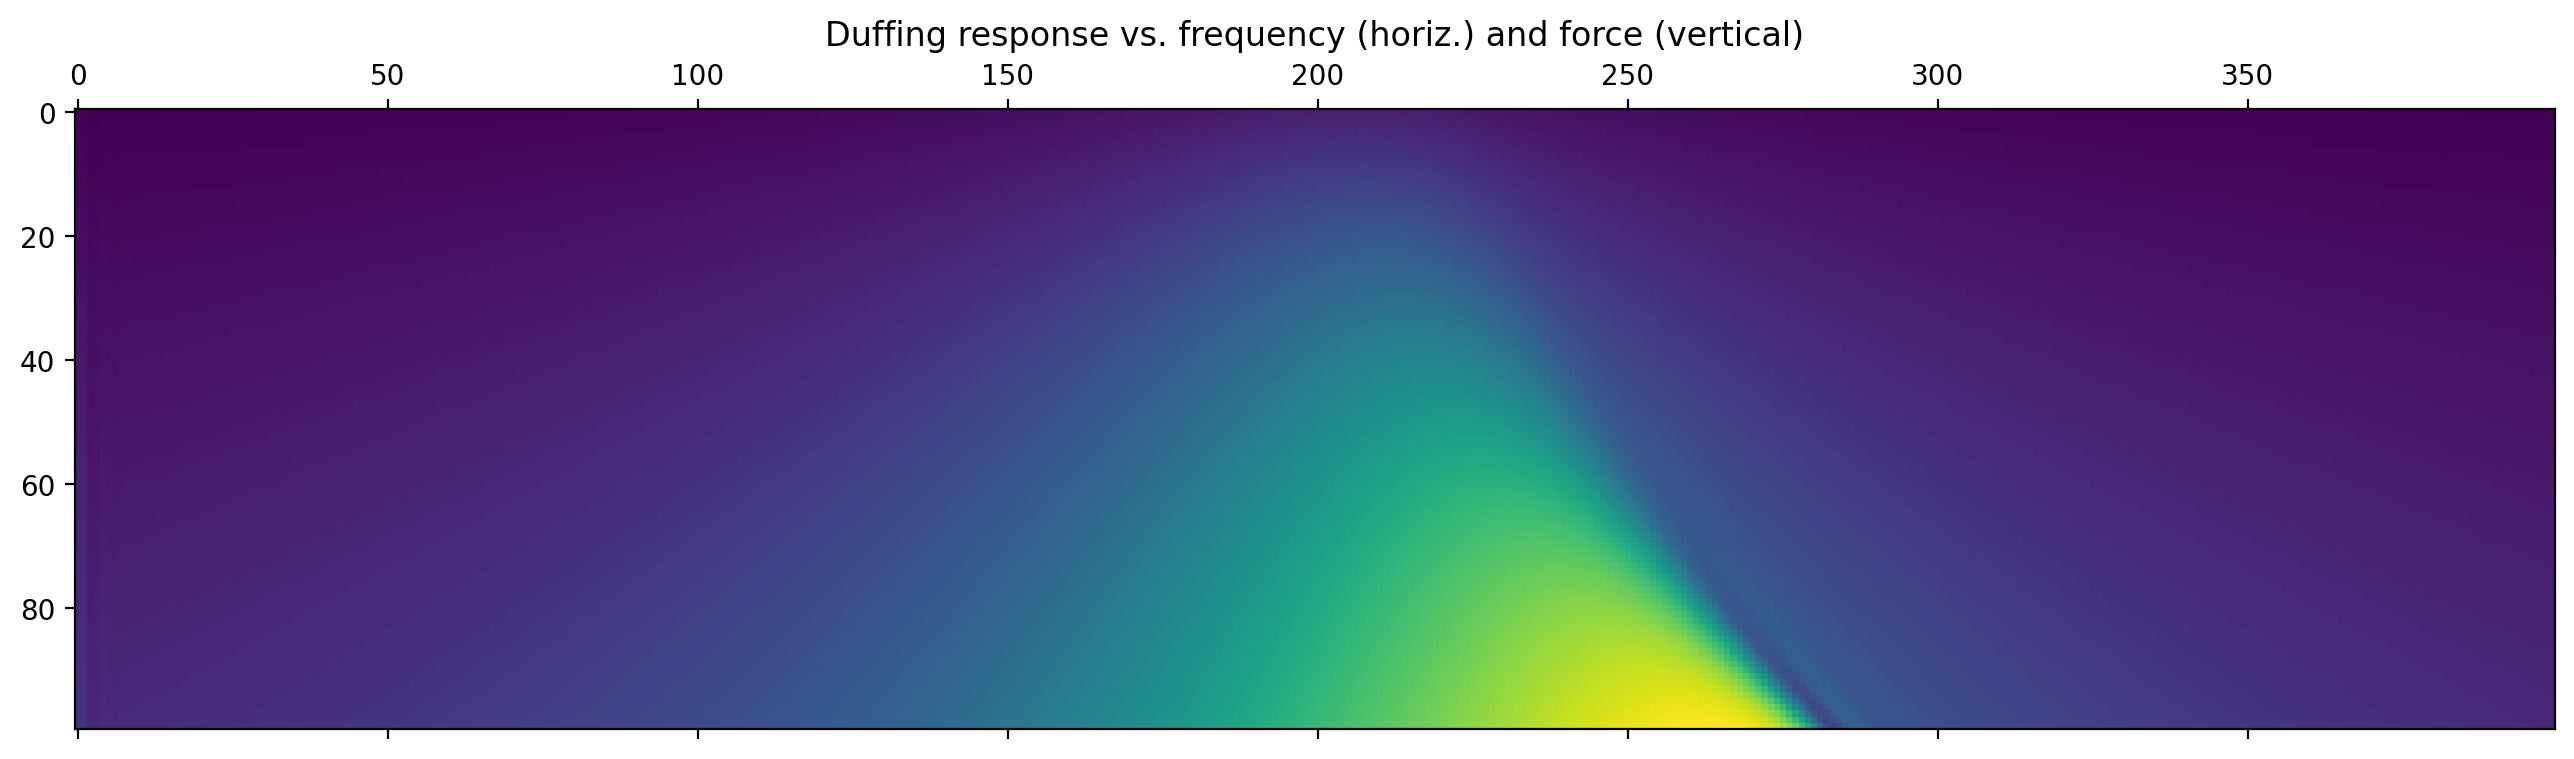

In [63]:
# Let us produce a frequency / force sweep to generate a 2D image of the type that could come from an experiment:
zs,ts,omegas = solve_duffing_force_batch( 0.0+0.01j, 0.0, 1.0, 
                      0.3, jnp.linspace(0.1,1.0,100), -4.0, 
                    +4.0,
                      200.0, 400 )

plt.matshow( jnp.abs(zs) )
plt.title("Duffing response vs. frequency (horiz.) and force (vertical)")
plt.show()

In [59]:
def produce_force_sweep_image(key, omega0,epsilon,gamma, npixels, 
                              omega_range, low_force, high_force, 
                              t_end, nsteps, noise_strength):
    zs,ts,omegas = solve_duffing_force_batch( 0.0+0.01j, omega0, gamma, 
                      epsilon, jnp.linspace(low_force,high_force,npixels), -omega_range, +omega_range,
                      t_end, nsteps )
    # downscale image (less data for the network to process):
    resized_img = jax.image.resize(jnp.abs(zs), (npixels,npixels), "cubic")
    # add noise:
    resized_img+= noise_strength * jax.random.normal(key, jnp.shape(resized_img) )
    
    # also produce images containing the frequency values
    # and the force values:
    freq_img = jnp.repeat( jnp.linspace(-omega_range, 
                            +omega_range, npixels)[None,:], npixels, axis=0 )
    force_img = jnp.repeat( jnp.linspace(low_force, 
                            high_force, npixels)[:,None], npixels, axis=1 )
    # stack all three images together, so that
    # the resulting axis 0 will represent the three channels:
    return jnp.stack( [resized_img, freq_img, force_img], axis=0 )

# a batched version,
# also compiled for speedup.
# for jit, static_argnums=[3,8] says that arguments index 4 and 9, 
# "npixels" and "nsteps" are static parameters
# and not jax arrays. If these change,
# a recompilation will be triggered automatically.
produce_force_sweep_image_batch = jax.jit( vmap( produce_force_sweep_image, 
                                       in_axes=[0,0,0,0,None,None,None,None,None,None,None], out_axes=0),
                                         static_argnums=[4,9])


# the function that puts everything together
# and will be called during the training loop:
def get_duffing_image_batch(key, batchsize, ranges, 
                            npixels, omega_range, 
                            low_force, high_force, t_end, nsteps,
                            noise_strength):
    subkey1, subkey2 = jax.random.split( key )
    omega0s, gammas, epsilons = random_parameter_vectors( subkey1, batchsize, ranges )
    
    # need to get many random keys, one for each
    # noisy sample in the batch:
    subkeys = jax.random.split( subkey2, batchsize )
    output = produce_force_sweep_image_batch( subkeys, omega0s,epsilons,gammas, 
                                        npixels, omega_range, 
                                        low_force, high_force, 
                                        t_end, nsteps, noise_strength )
    return ( output, jnp.stack([omega0s,gammas,epsilons], axis=1) )

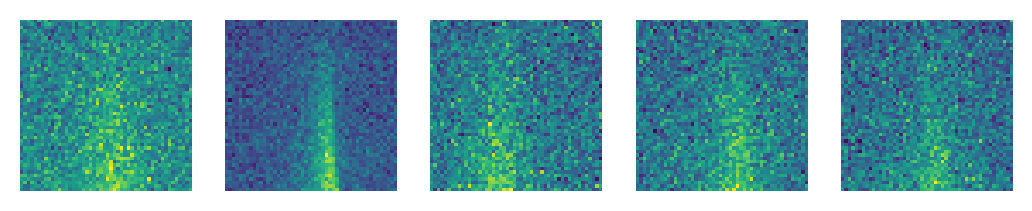

In [66]:
value_ranges = [[-1.,1.],[0.5,1.5],[0.0,0.15]] # omega0, gamma, epsilon
subkey, key = jax.random.split(key)
img_batch,_ = get_duffing_image_batch( subkey, 5, value_ranges, 
                        50, 4.0, 0.1, 1.0, 200., 400, 0.5)

fig,ax=plt.subplots(ncols=5)
for j in range(5):
    ax[j].matshow(img_batch[j,0])
    ax[j].axis('off')

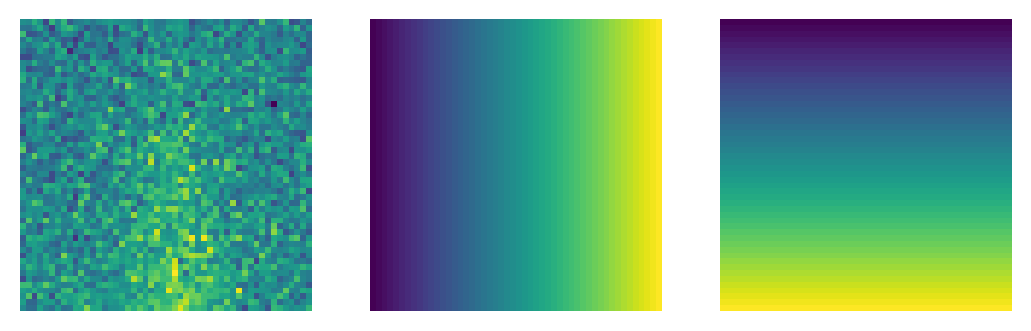

In [67]:
fig,ax=plt.subplots(ncols=3)
for j in range(3):
    ax[j].matshow(img_batch[0,j])
    ax[j].axis('off')

In [71]:
# Hyperparameters and initialization

num_physics_parameters = 3 # output dimension
npixels = 50 # size of images will be npixels * npixels
learning_rate = 1e-3

key = jax.random.key( 42 )

subkey, key = jax.random.split(key)
params = CNN_init_params( subkey, 
                pixel_rows=npixels, pixel_cols=npixels,
                num_channels=[3,30,30,30,10], 
                kernel_sizes=[3,3,3,3],
                final_dense_layers=[50,num_physics_parameters] )

optimizer = optax.adam( learning_rate )
opt_state = optimizer.init( params )

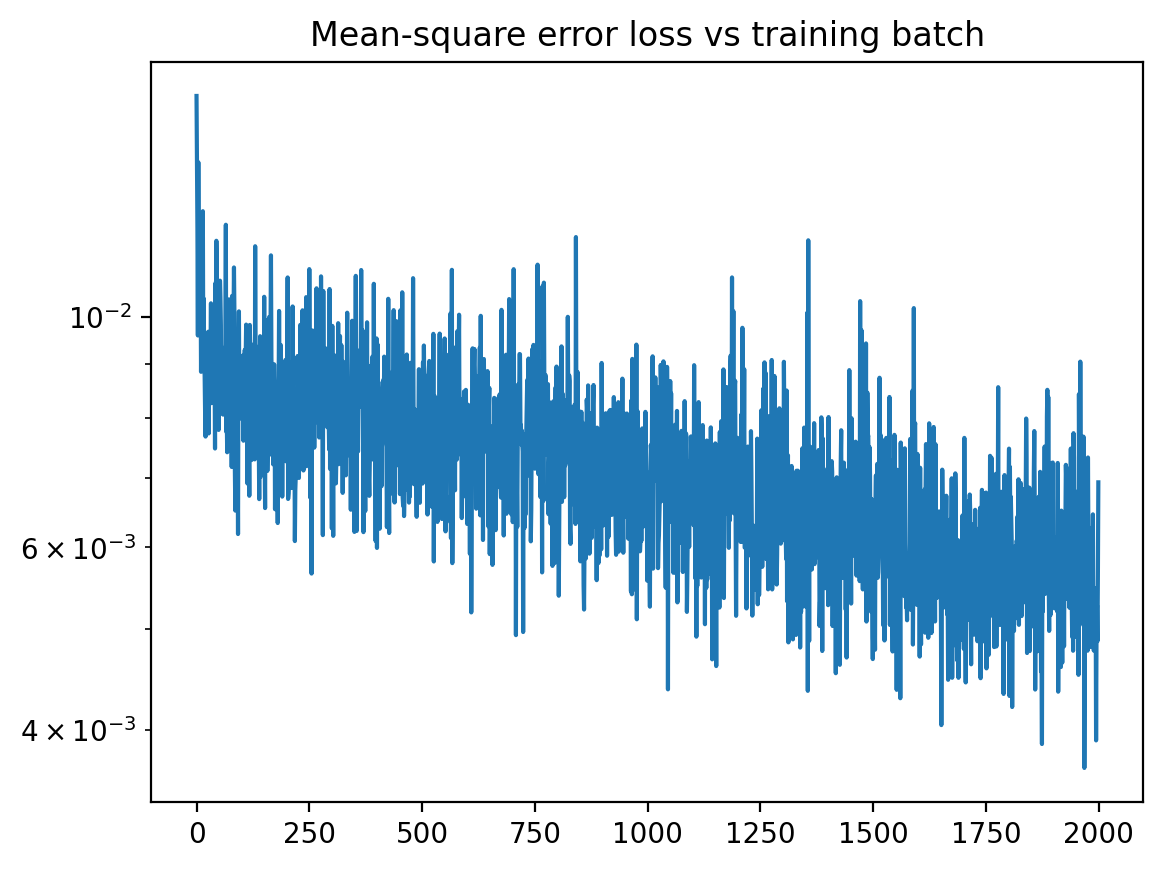

In [78]:
# CNN training loop

# training parameters
num_training_batches = 2000
batchsize = 64

# parameters for the training batches:
value_ranges = [[-1.,1.],[0.5,1.5],[0.0,0.15]] # omega0, gamma, epsilon
noise_strength = 0.5
omega_range = 4.0 # sweep -omega_range..+omega_range
t_end = 200.0 # duration of frequency sweep
nsteps = 400 # time steps for solving dynamics in sweep
low_force = 0.1 # force sweep range
high_force = 2.0

losses=[]

# run this cell multiple times to continue training!

for idx_batch in range(num_training_batches):
    # get training batch:
    subkey,key = jax.random.split( key )
    x, y_target = get_duffing_image_batch( subkey,
                                batchsize, value_ranges, npixels,
                                omega_range, low_force, high_force,
                                t_end, nsteps,
                                noise_strength)    
    
    # get loss and its gradient with respect to network parameters:
    loss, grads = mse_loss_conv_batch_val_grad( x, y_target, params )

    # update the network parameters:
    updates, opt_state = optimizer.update( grads, opt_state)
    params = optax.apply_updates( params, updates )

    # add the loss to the list:
    losses.append(loss)

plt.plot( losses )
plt.yscale( "log" )
plt.title("Mean-square error loss vs training batch")
plt.show()

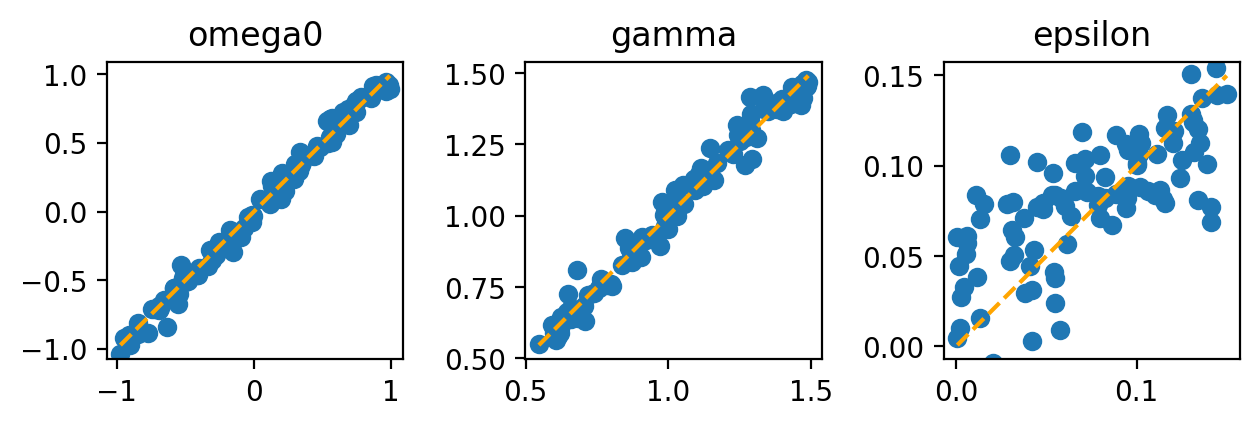

In [79]:
# Performance check

validation_batchsize = 100

subkey,key = jax.random.split( key )
x, y_target = get_duffing_image_batch( subkey,
                                validation_batchsize, value_ranges, npixels,
                                omega_range, low_force, high_force,
                                t_end, nsteps,
                                noise_strength) 
y = NN_conv_batch( x, params )


fig,ax = plt.subplots(ncols=3)
for idx, label in enumerate(["omega0","gamma","epsilon"]):
    ax[idx].scatter(y_target[:,idx],y[:,idx])
    min_max_values=[jnp.min(y_target[:,idx]),jnp.max(y_target[:,idx])]
    ax[idx].plot(min_max_values,min_max_values,"--",color="orange")
    ax[idx].set_ylim(ax[idx].get_xlim())
    ax[idx].set_title(label)
    ax[idx].set_aspect(1.0)
fig.tight_layout()

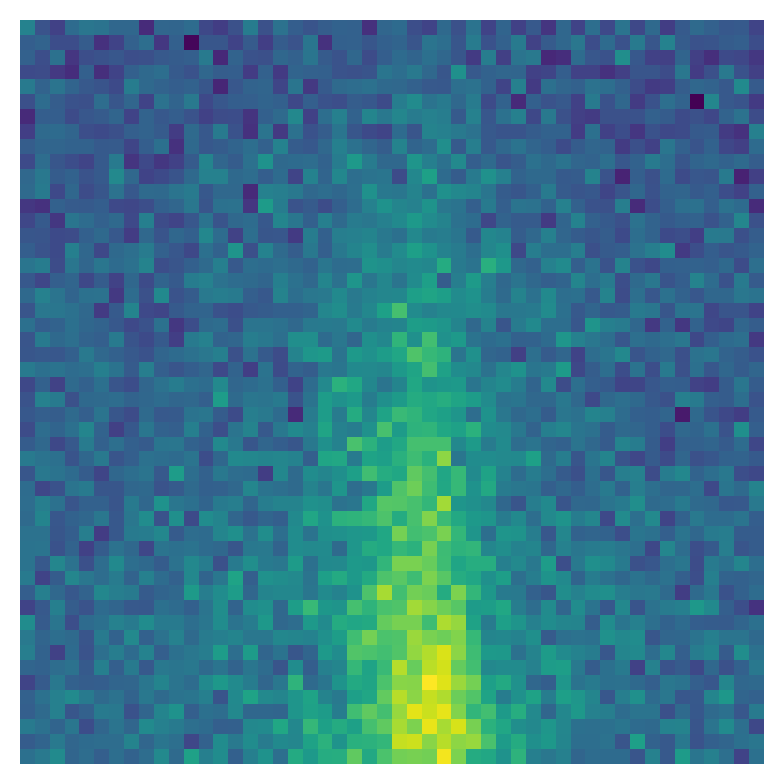

Physical parameters (omega0, gamma, epsilon):
True: [0.15202904 0.88211596 0.01192237]
NN:   [0.15486339 0.8770992  0.03864255]


In [102]:
# Prediction visualization

idx = 8 # sample index
plt.matshow( x[idx,0] )
plt.axis('off')
plt.show()
print("Physical parameters (omega0, gamma, epsilon):")
print(f"True: {y_target[idx]}")
print(f"NN:   {y[idx]}")